# **SYMBOLIC MACHINE LEARNING**



---



***INSTALL GDAL :***

In [1]:
!pip install gdal

***MOUNT DRIVE ON GOOGLE COLLABORATORY :***


In [0]:
from google.colab import drive
drive.mount('/content/drive')



---



***IMPORT PACKAGES :***

In [0]:
import gdal
from gdalconst import GA_ReadOnly 
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import subprocess 

#IMAGE SIZE = 1000 X 1000 pixels
IMG_SIZE=1000



---



***GDAL : CROPPING MANNHEIM AREA-SENTINEL-2 IMAGE FROM CORINE LAND COVER(CLC)-EUROPE AREA, COMPRESSING RESULTING TIF FILES TO JPG***

In [0]:
data=gdal.Open('mannheim.tif',GA_ReadOnly) 
geoTransform=data.GetGeoTransform() 
minx=geoTransform[0] 
maxy=geoTransform[3] 
maxx = minx + geoTransform[1] * data.RasterXSize 
miny = maxy + geoTransform[5] * data.RasterYSize 
subprocess.call('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff clc.tif img_out.tif', shell=True) 
subprocess.call('gdal_translate -of JPEG -co QUALITY=90 -co PROGRESSIVE=ON -outsize 1000 1000 -r bilinear clc.tif Y.jpg')
subprocess.call('gdal_translate -of JPEG -co QUALITY=90 -co PROGRESSIVE=ON -outsize 1000 1000 -r bilinear mannheim.tif X.jpg')





---



***VISUALIZE INPUT DATA (X) : (SENTINEL-2 IMAGE-MANNHEIM AREA)***

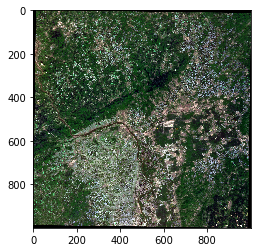

In [117]:
image = cv2.imread('/content/drive/My Drive/Colab_Notebooks/X.jpg')
plt.imshow(image)



---



***VISUALIZE REFERENCE IMAGE (Y): CORINE LAND COVER(CLC) - SAME REGION OF MANNHEIM***

 ***3 CLASSES :
 WHITE(0) = BUILT UP AREA , 
 DARK BLUE(0) = RIVER/WATER BODIES , 
 OTHER COLORS(2) = OTHER OBJECTS***


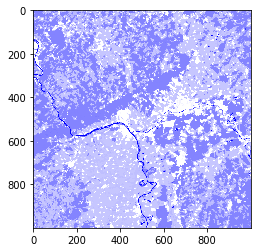

In [118]:
image = cv2.imread('/content/drive/My Drive/Colab_Notebooks/Y.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [119]:
#IMPORT SENTNEL IMAGE OF MANNHEIM AREA
tif1=gdal.Open('/content/drive/My Drive/Colab_Notebooks/X.jpg')
print ("TOTAL BANDS COUNT: " + str(tif1.RasterCount)+(" = RGB"))
rband = tif1.GetRasterBand(1).ReadAsArray()
gband = tif1.GetRasterBand(2).ReadAsArray()
bband = tif1.GetRasterBand(3).ReadAsArray()




TOTAL BANDS COUNT: 3 = RGB




---



***STEP 1 : DATA QUANTIZATION-SEQUENCING***

In [0]:
#CONVERT RGB BANDS AS INPUT FEATURE SEQUENCES
#QUANTIZATION

rband_list=rband.flatten().tolist()
#rband_list = [round(x/8) for x in rband_list]

gband_list=gband.flatten().tolist()
#gband_list = [round(x/8) for x in gband_list]

bband_list=bband.flatten().tolist()
#bband_list = [round(x/8) for x in bband_list]


In [0]:
#CREATE RANDOM Y WITH FEW CLASSES, LATER READ IMAGES
Y= np.random.randint(0, 3, size=(IMG_SIZE, IMG_SIZE))
Y_list=Y.flatten().tolist()

***SEQUENCE LIST AND ANTECEDENT-CONSEQUENT LIST(X->Y)***

In [0]:
sequences_list=[]
ante_consq_list=[]

In [123]:
for i in range(IMG_SIZE*IMG_SIZE):
  sequences_list.append((rband_list[i],gband_list[i],bband_list[i]))
  ante_consq_list.append((rband_list[i],gband_list[i],bband_list[i],Y_list[i]))

print('BUILDING DATA DONE')


BUILDING DATA DONE


***RANDOM EXAMPLE - DATA STRUCTURE (R, G, B, CLASS_LABEL)***

In [124]:
print ((ante_consq_list[9339]))

(92, 108, 100, 0)


***FIND UNIQUE SEQUENCES(X-cap) AND COUNT***

In [125]:
print('UNIQUE SEQUENCES COUNT: ')
print(len(list(set(sequences_list))))
unique_X_sequences=list(set(sequences_list))

UNIQUE SEQUENCES COUNT: 
321278




---



***STEP 2:***

*   ***ASSOCIATION ANALYSIS***
*   ***EVIDENCE BASED NORMALIZED DIFFERENTIAL INDEX(ENDI) MEASURE***




***HELPER FUNCTIONS:***

In [0]:
#ONE VARIATION OF ENDI INTERESTINGNESS MEASURE
def calculate_ENDI(positive,negative):
  if (positive==0) and (negative==0) : return 0
  return (positive-negative)/(positive+negative)

In [0]:
#POSITIVE EVIDENCES
def positive_count(sequence,class_name):
  item = list(sequence)
  item.append(class_name)
  c=counter[tuple(item)]
  return c


#NEGATIVE EVIDENCES
def negative_count(sequence, class_list):
  negative_classcount=0
  for c in  class_list:
    item = list(sequence)
    item.append(c)
    negative_classcount=negative_classcount+counter[tuple(item)]

  return negative_classcount



In [0]:
#COUNT OCCURANCE FREQUENCIES OF EACH UNIQUE SEQUENCE
counter=Counter(ante_consq_list)

***CALCULATE ENDI MEASURE FOR ALL THE CLASSES PER SEQUENCE DATA***

In [0]:
#GENERATE A DICTIONARY OF THE FORM : {(unique sequence) : [ENDI MEASURE-CLASS 0, ENDI MEASURE-CLASS 2, ENDI MEASURE-CLASS 3 ]}
ENDI_table_dictionary={}

for i in range(len(unique_X_sequences)):
  seq=unique_X_sequences[i]
  ENDI_class_0=calculate_ENDI(positive_count(seq,0),negative_count(seq,[1,2]))
  ENDI_class_1=calculate_ENDI(positive_count(seq,1),negative_count(seq,[0,2]))
  ENDI_class_2=calculate_ENDI(positive_count(seq,2),negative_count(seq,[0,1]))
  ENDI_table_dictionary[seq]=[ENDI_class_0,ENDI_class_1,ENDI_class_2]

#PRINT RANDOM DATA POINT
#print(ENDI_table_dictionary[unique_X_sequences[31050]])




---



***STEP 3 : CLASSIFICATION***

In [130]:
#CLASSIFY ANY NEW IMAGE
#IMPORT SENTNEL IMAGE OF MANNHEIM AREA (SAME IMAGE FOR DEMO)
new_image=gdal.Open('/content/drive/My Drive/Colab_Notebooks/X.jpg')
rband = new_image.GetRasterBand(1).ReadAsArray()
gband = new_image.GetRasterBand(2).ReadAsArray()
bband = new_image.GetRasterBand(3).ReadAsArray()

rband_list=rband.flatten().tolist()
gband_list=gband.flatten().tolist()
bband_list=bband.flatten().tolist()

#SAMPLE PREDICTION
ENDI_vals=ENDI_table_dictionary[unique_X_sequences[80010]]

max_val = max(ENDI_vals)
index_max = ENDI_vals.index(max_val)

print("CLASSIFICATION RESULT - BELONGS TO CLASS: ",index_max)



CLASSIFICATION RESULT - BELONGS TO CLASS:  2


In [0]:
#TO DO : CORRECTLY READ COLOR LABELS OF REFERENCE DATA, VISUALIZATION OF CLASSIFICATION RESULTS